<a href="https://colab.research.google.com/github/abalaji-blr/EIP_P2/blob/master/CIFAR10_GradCAM_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyze CIFAR10 using GradCAM

**Objective**:
* Analyze the CIFAR 10 failures using GradCAM

**Approach:**
* Use Pretrained ResNet18 model

## Get the Dataset

In [1]:
import numpy as np
from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
# load cifar10 dataset
((trainX, trainY), (testX, testY)) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
print(trainX.shape, trainY.shape)

(50000, 32, 32, 3) (50000, 1)


In [4]:
print(testX.shape, testY.shape)

(10000, 32, 32, 3) (10000, 1)


### Distribution of data

In [5]:
np.unique(trainY)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
np.unique(trainY, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

### Visualize Data

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog',      'frog',     'horse', 'ship', 'truck']

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
trainX[0].shape

(32, 32, 3)

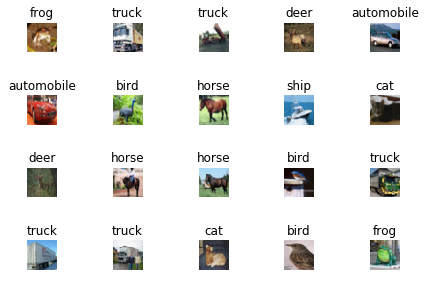

In [10]:
# show 20 images
num_rows = 4
num_cols =5
fig, ax = plt.subplots(num_rows, num_cols)
for i in range(0, num_rows * num_cols):
    row = int(i / num_cols)
    col = int(i % num_cols)
    #print(row)
    ax[row, col].axis('off')
    ax[row, col].imshow(trainX[i])
    
    label_id = int(trainY[i])
    ax[row, col].set_title(label_names[label_id])
    #ax[row, col].tight()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Use Pretrained Model

In [11]:
pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-pkue0w4s
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-pkue0w4s
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-tr_y0rti/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
import keras
from classification_models.resnet import ResNet18, preprocess_input


In [0]:
n_classes = 10

# build model
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False) # output 1x1x512
# we need 10 classes
x = keras.layers.Conv2D(10, (1,1))(base_model.output)
x = keras.layers.GlobalAveragePooling2D()(x)
#output = keras.layers.Dense(n_classes, activation='softmax')(x)

output = keras.layers.core.Activation('softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

In [0]:
#base_model.summary()

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_55 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_55[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
# freezing most of the layers results in low accuracy.
# on the other hand, train all layers as training time is less.
# freeze base layers
#for layer in base_model.layers:
#  #print (layer.trainable)
 # layer.trainable = False

In [21]:
model.get_layer('stage4_unit2_conv2').trainable

True

### Preprocess Data

In [0]:
pre_trainX = preprocess_input(trainX)

In [23]:
pre_trainX.shape

(50000, 32, 32, 3)

In [0]:
#pre_trainX[0]

In [0]:
#trainX[0]

### Split Train Data

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(trainX, trainY, test_size=0.20, random_state=123)

In [26]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 1)
(10000, 1)


In [27]:
np.unique(y_val, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1036,  971,  979, 1017, 1046,  993,  970,  950, 1022, 1016]))

### Vectorize the labels

In [0]:
from sklearn.preprocessing import LabelBinarizer

In [0]:
lb = LabelBinarizer()

In [0]:
y_train_bin = lb.fit_transform(y_train)

In [0]:
y_val_bin = lb.transform(y_val)

In [32]:
y_train_bin[0:3]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

### Compile Model

In [33]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

W0707 05:14:11.592872 140506897229696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Train data

In [34]:
H1 = model.fit(X_train, y_train_bin, validation_data=(X_val, y_val_bin), epochs=5)

W0707 05:14:17.442764 140506897229696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 41s 1ms/step - loss: 1.0621 - acc: 0.6362 - val_loss: 0.7654 - val_acc: 0.7327
Epoch 2/5
40000/40000 [==============================] - 35s 878us/step - loss: 0.6663 - acc: 0.7692 - val_loss: 0.6369 - val_acc: 0.7794
Epoch 3/5
40000/40000 [==============================] - 35s 879us/step - loss: 0.5246 - acc: 0.8183 - val_loss: 0.6281 - val_acc: 0.7864
Epoch 4/5
40000/40000 [==============================] - 35s 883us/step - loss: 0.4163 - acc: 0.8550 - val_loss: 0.6196 - val_acc: 0.7982
Epoch 5/5
40000/40000 [==============================] - 35s 882us/step - loss: 0.3266 - acc: 0.8856 - val_loss: 0.6420 - val_acc: 0.7967


In [0]:
## Unfreeze some of the mid and later layers
#print(len(base_model.layers))

In [0]:
''' 
cnt = 0
for layer in base_model.layers:
  if cnt < 25:
    layer.trainable = False
  else :
    layer.trainable = True
  cnt = cnt +1
'''

' \ncnt = 0\nfor layer in base_model.layers:\n  if cnt < 25:\n    layer.trainable = False\n  else :\n    layer.trainable = True\n  cnt = cnt +1\n'

In [35]:
## let's train for 5 more epochs
H2 = model.fit(X_train, y_train_bin, validation_data=(X_val, y_val_bin), epochs=5)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 35s 885us/step - loss: 0.2610 - acc: 0.9079 - val_loss: 0.6731 - val_acc: 0.7969
Epoch 2/5
40000/40000 [==============================] - 35s 885us/step - loss: 0.2045 - acc: 0.9270 - val_loss: 0.6983 - val_acc: 0.8005
Epoch 3/5
40000/40000 [==============================] - 35s 886us/step - loss: 0.1620 - acc: 0.9430 - val_loss: 0.7312 - val_acc: 0.8019
Epoch 4/5
40000/40000 [==============================] - 35s 884us/step - loss: 0.1261 - acc: 0.9561 - val_loss: 0.7616 - val_acc: 0.8023
Epoch 5/5
40000/40000 [==============================] - 35s 885us/step - loss: 0.1103 - acc: 0.9619 - val_loss: 0.8071 - val_acc: 0.7976


### Save Model

In [0]:
model.save('cifar10_v3.hdf5')

In [37]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp cifar10_v3.hdf5 '/content/gdrive/My Drive/App/EIP_Phase2'

### Predict

In [0]:
pred = model.predict(X_val)

In [0]:
pred = np.argmax(pred, axis=1)

In [41]:
pred[0:5]

array([4, 2, 1, 2, 8])

In [42]:
y_val[0:5]

array([[4],
       [2],
       [1],
       [2],
       [8]], dtype=uint8)

## Collect Metrics

In [0]:
from sklearn.metrics import classification_report

In [44]:
print(classification_report(y_val, pred, target_names = label_names))

              precision    recall  f1-score   support

    airplane       0.81      0.87      0.84      1036
  automobile       0.92      0.85      0.89       971
        bird       0.77      0.70      0.73       979
         cat       0.60      0.70      0.65      1017
        deer       0.74      0.81      0.77      1046
         dog       0.73      0.63      0.68       993
        frog       0.83      0.85      0.84       970
       horse       0.89      0.77      0.82       950
        ship       0.87      0.90      0.89      1022
       truck       0.87      0.88      0.88      1016

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



### Collect the failures

In [0]:
pred_fail = []
## collect the failing cases
for i in range(0, len(y_val)) :
  if y_val[i] != pred[i] :
    pred_fail.append(i)

In [46]:
print(len(pred_fail))

2024


In [47]:
fail_id = pred_fail[0]
print(fail_id)

9


In [48]:
#print(y_val[6], pred[6])
print(y_val[fail_id], pred[fail_id])

[1] 9


In [49]:
print('actual:', label_names[int(y_val[fail_id])], ' predicted: ', label_names[pred[fail_id]])

actual: automobile  predicted:  truck


## Visualize few failures

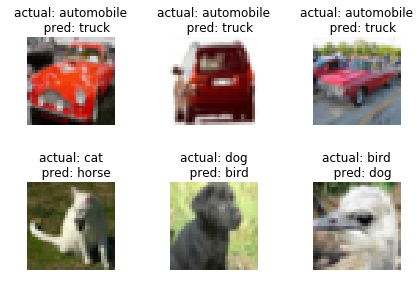

In [50]:
num_rows = 2
num_cols = 3
fig, ax = plt.subplots(num_rows, num_cols)
for i in range(0, num_rows * num_cols):
    row = int(i / num_cols)
    col = int(i % num_cols)
    #print(row)
    ax[row, col].axis('off')
    img_id = pred_fail[i]
    #print(img_id)
    ax[row, col].imshow(X_val[img_id])
    
    actual_name = label_names[int(y_val[img_id])]
    pred_name   = label_names[pred[img_id]]
    #print('actual:', actual_name, ' pred: ', pred_name)
    
    title = 'actual: ' + actual_name + '\n   pred: ' + pred_name
    ax[row, col].set_title(title)
     
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Use Grad-CAM to analyze failures

In [0]:
import keras.backend as K


*  [Gradient Weighted Class Activation Map - Grad-CAM blog](http://www.hackevolve.com/where-cnn-is-looking-grad-cam/)

In [0]:

# get gradient weighted class activation map
# inputs: image, 
#         pred_class 
#         and the layer to look at for class activation maps.
#
def get_GradCAM(img, pred_class, layerNameForCAM, num_channel):
  #get the conv layer
  last_conv_layer = model.get_layer(layerNameForCAM)
  
  class_output = model.output[:, pred_class]
  
  # get the gradients
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  
  x = np.expand_dims(img, axis=0)
  
  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  for i in range(num_channel):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  return conv_layer_output_value

In [0]:
def get_heat_map(img, conv_layer_output_value):
  ## heatmap
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  superimposed_img = cv2.addWeighted(fail_img, 0.6, heatmap, 0.4, 0)
  return superimposed_img


In [0]:
import cv2
from google.colab.patches import cv2_imshow

In [0]:
def display_images(img, actual_name, heatmap_img, pred_name):
  plt.imshow(img)
  act_label = 'actual: ' + actual_name
  plt.title(act_label)
  
  plt.show()
  
  #heatmap
  plt.imshow(heatmap_img)
  pred_label = 'predicted: ' + pred_name
  plt.title(pred_label)
  
  plt.show()

In [0]:
def display_images_side_by_side(img, actual_name, heatmap_img, pred_name):
  fig, axes = plt.subplots(1,2)
  axes[0].imshow(img)
  axes[0].set_title(actual_name)
  
  axes[1].imshow(heatmap_img)
  axes[1].set_title(pred_name)
  plt.show()
  
def cv_display_images(img, actual_name, heatmap_img, pred_name):
  cv2_imshow(img)
  #act_label = 'actual: ' + actual_name
   
  #heatmap
  cv2_imshow(heatmap_img)
  
 

### Group the failures by class name

In [0]:
group_fail_list = [ [], [], [], [], [], 
               [], [], [], [], [] ]

# group the first 50 failures
for i in range(0,50):
  fail_id = pred_fail[i]
  orig_label_id = int(y_val[fail_id])
  #print(orig_label_id)
  
  group_fail_list[orig_label_id].append(fail_id)

In [58]:
group_fail_list

[[178, 208, 210, 212, 232, 267],
 [9, 10, 13, 80, 99],
 [29, 34, 169],
 [19, 55, 82, 84],
 [54, 57, 129, 144, 180, 211],
 [27, 42, 58, 75, 81, 87, 111, 135, 145, 170, 181, 185, 249],
 [31, 50, 126, 206, 234],
 [148, 183],
 [66],
 [102, 138, 146, 215, 224]]

------------- actual: airplane ----------------


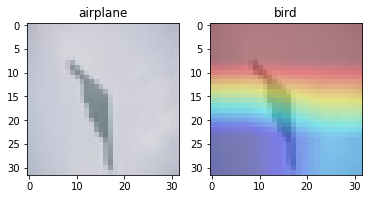

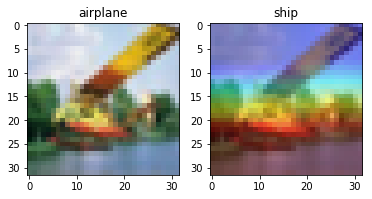

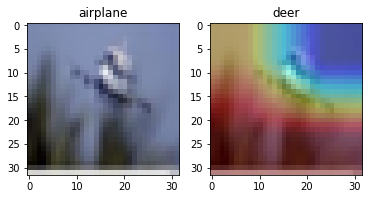

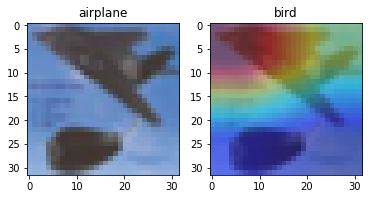

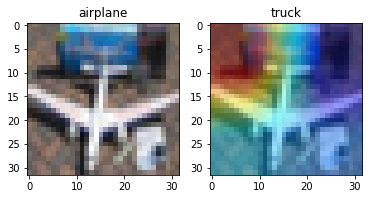

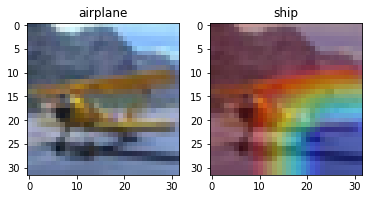

------------- actual: automobile ----------------


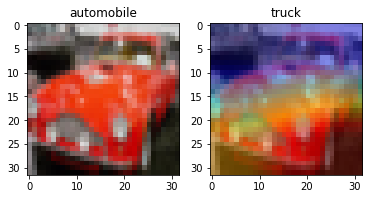

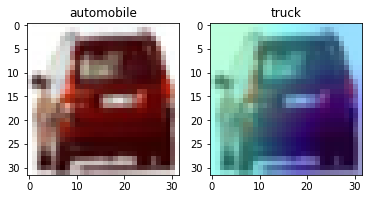

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


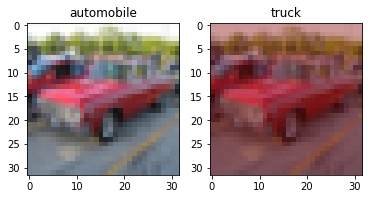

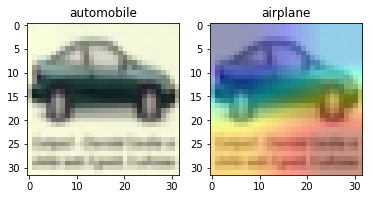

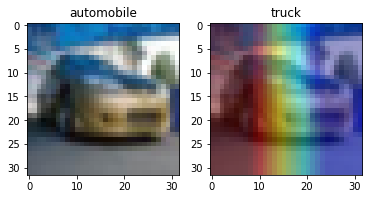

------------- actual: bird ----------------


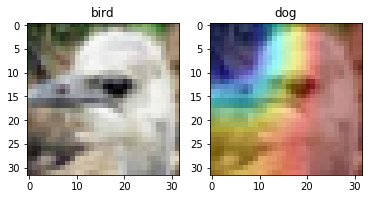

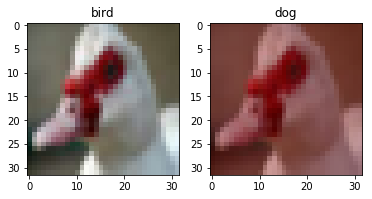

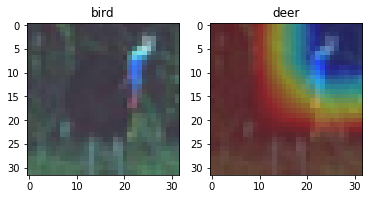

------------- actual: cat ----------------


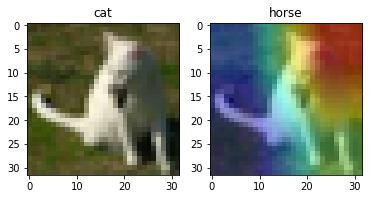

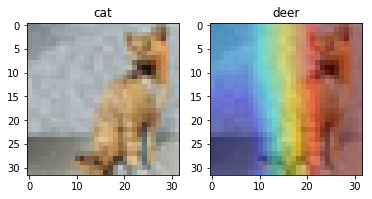

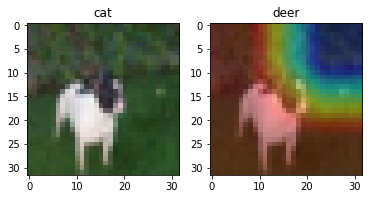

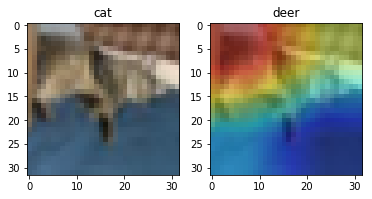

------------- actual: deer ----------------


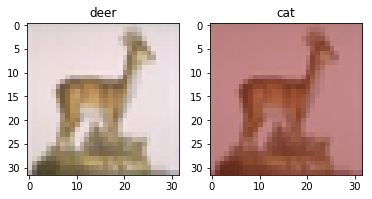

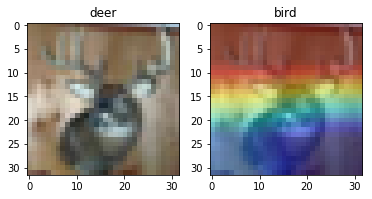

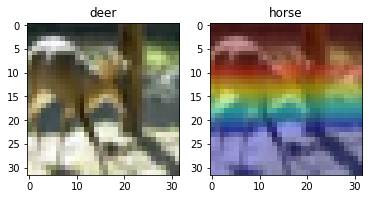

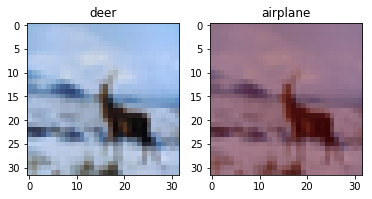

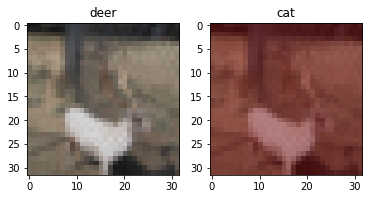

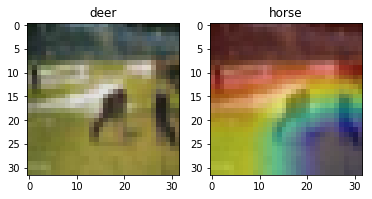

------------- actual: dog ----------------


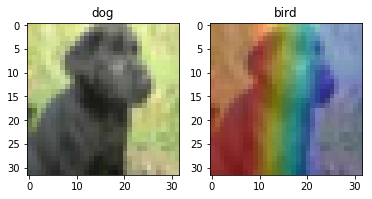

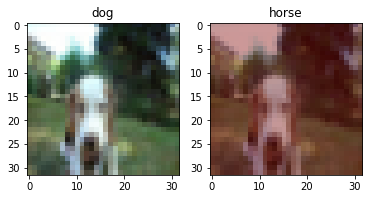

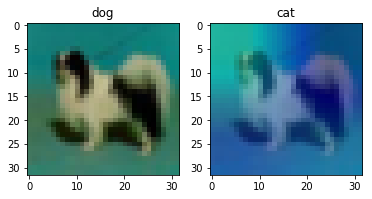

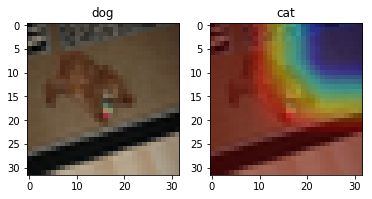

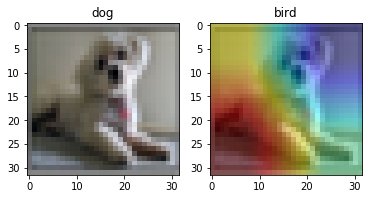

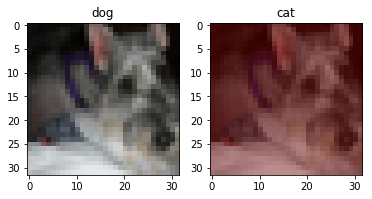

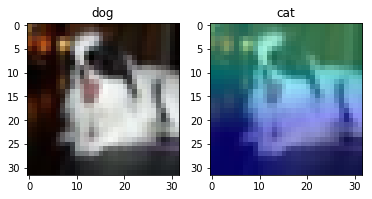

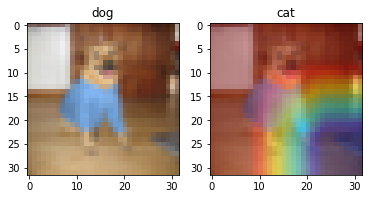

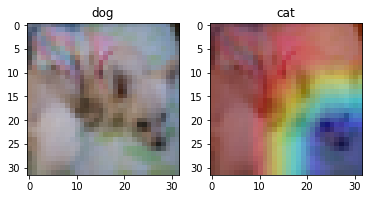

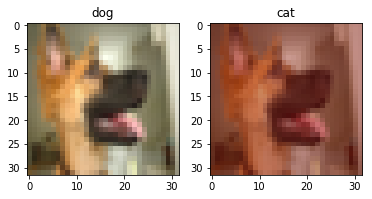

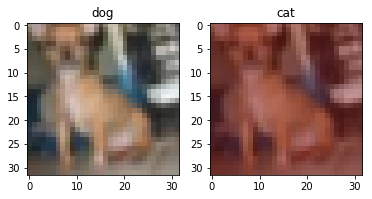

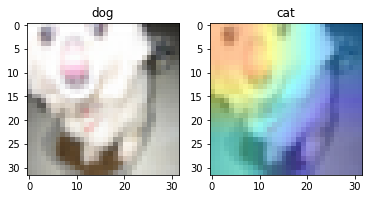

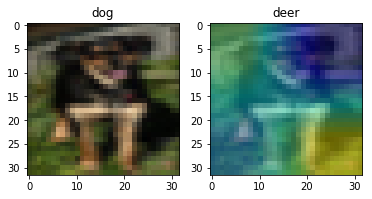

------------- actual: frog ----------------


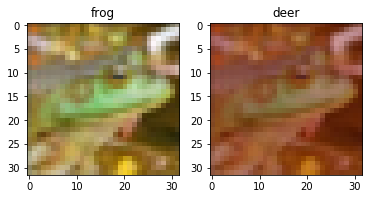

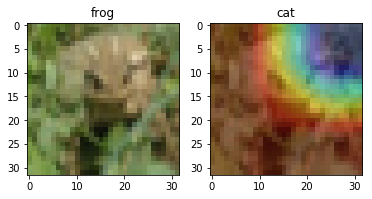

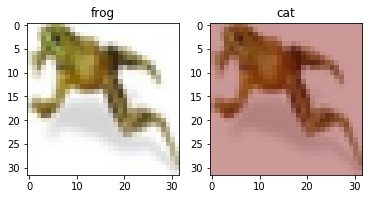

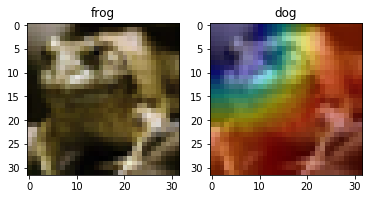

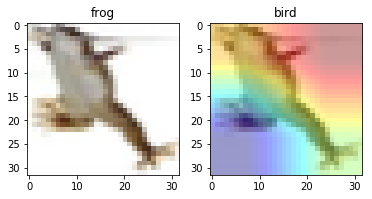

------------- actual: horse ----------------


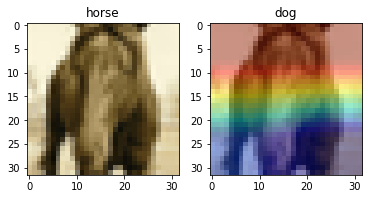

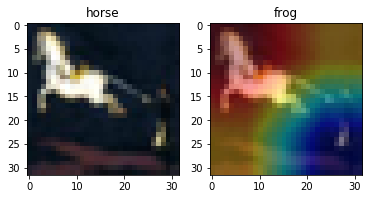

------------- actual: ship ----------------


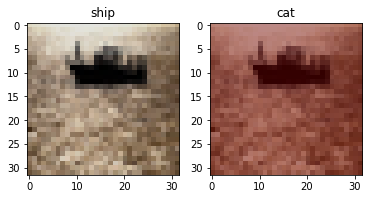

------------- actual: truck ----------------


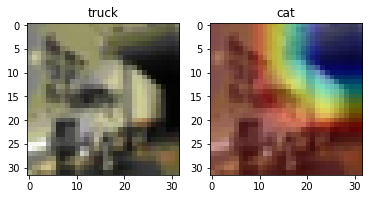

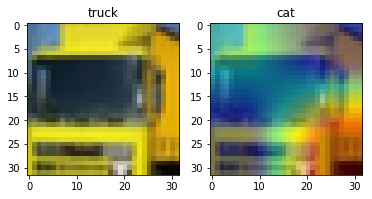

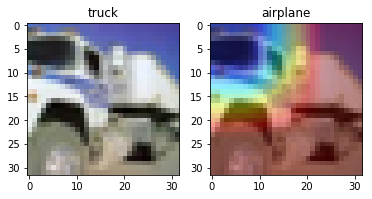

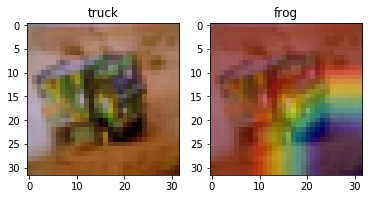

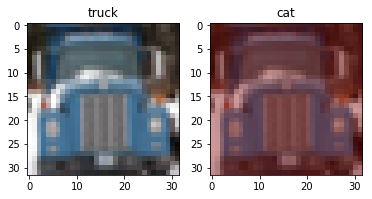

In [59]:

# get the last conv layer - stage4_unit2_conv2 (1x1x512) to look at
#conv_layer_name = 'stage4_unit2_conv2'  # 1x1x512 - low res
 
conv_layer_name = 'stage3_unit2_conv2'  # 2x2x256 - try some intermediate conv layer
num_channel = 256

# show 5 failures
for i in range(0, 10):
  print('------------- actual:', label_names[i], '----------------')
  for fail_id in  group_fail_list[i]:
    # get pred class
    #fail_id = pred_fail[i]
    pred_class = pred[fail_id]

    # get the image
    fail_img = X_val[fail_id]

    conv_layer_out = get_GradCAM(fail_img, pred_class, conv_layer_name, num_channel)
  
    heatmap_img = get_heat_map(fail_img, conv_layer_out)
  
    actual_label = label_names[int(y_val[fail_id])]
    pred_label   = label_names[pred[fail_id]]
  
    #display_images(fail_img, actual_label, heatmap_img, pred_label)
    display_images_side_by_side(fail_img, actual_label, heatmap_img, pred_label)
    #cv_display_images(fail_img, actual_label, heatmap_img, pred_label)
  